using torchdefeq for spiral system solving
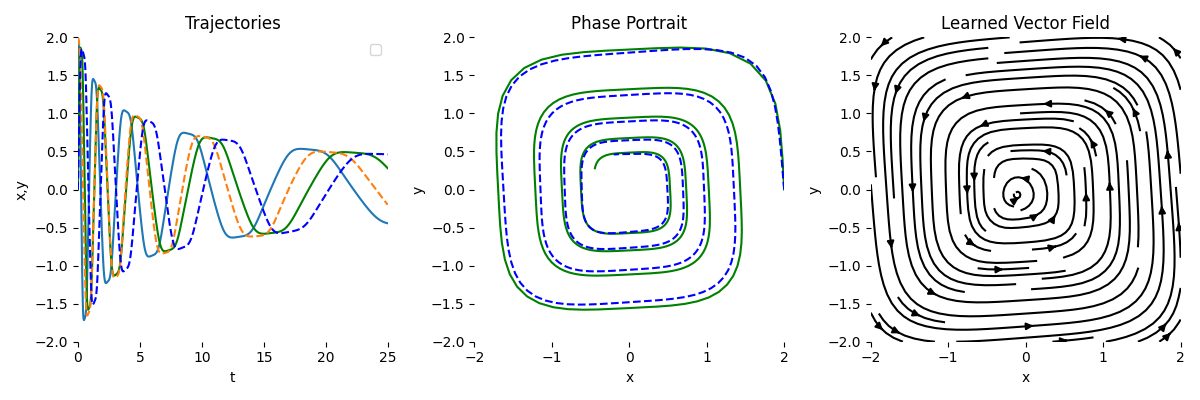

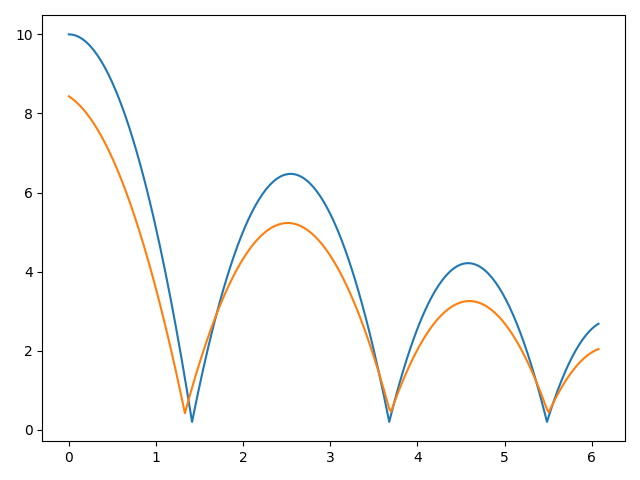

using custom network and implementation: 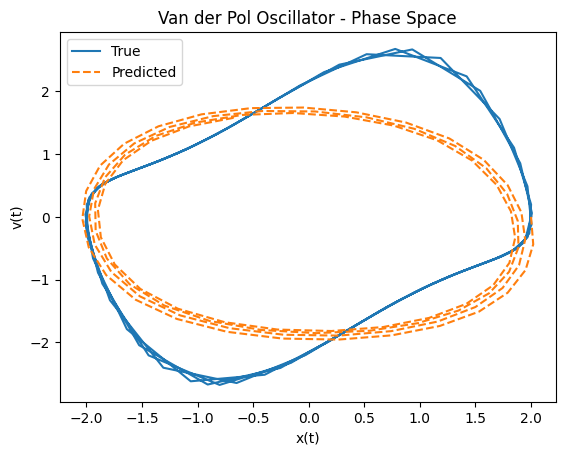

Implementation of using neural ode to solve vander pol oscillator

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [56]:
class VanDerPolODE(nn.Module):
    def __init__(self, mu=1.0):
        super(VanDerPolODE, self).__init__()
        self.mu = torch.tensor(mu)

    def forward(self, t, y):
        x, v = y[..., 0], y[..., 1]
        dxdt = v
        dvdt = self.mu * (1 - x**2) * v - x
        return torch.stack([dxdt, dvdt], dim=-1)

# class NeuralVanDerPol(nn.Module):
#     def __init__(self):
#         super(NeuralVanDerPol, self).__init__()
#         self.fc1 = nn.Linear(2, 50)
#         self.fc2 = nn.Linear(50, 50)
#         self.fc3 = nn.Linear(50, 2)

#     def forward(self, t, y):
#         out = torch.tanh(self.fc1(y))
#         out = torch.tanh(self.fc2(out))
#         return self.fc3(out)

class NeuralVanDerPol(nn.Module):
    def __init__(self):
        super(NeuralVanDerPol, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 2)

    def forward(self, t, y):
        out = torch.tanh(self.fc1(y))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        return self.fc4(out)




In [57]:

def runge_kutta_ode_solver(ode_func, y0, t_span, step_size=0.01):
    t_values = np.arange(t_span[0], t_span[1], step_size)
    y_values = [y0]
    
    for t in t_values[:-1]:
        y = y_values[-1]
        k1 = ode_func(t, y)
        k2 = ode_func(t + 0.5 * step_size, y + 0.5 * step_size * k1)
        k3 = ode_func(t + 0.5 * step_size, y + 0.5 * step_size * k2)
        k4 = ode_func(t + step_size, y + step_size * k3)
        y_next = y + (step_size / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        y_values.append(y_next)
        
    return torch.stack(y_values), torch.tensor(t_values)

def generate_data(mu, t_span, y0, step_size=0.01):
    van_der_pol = VanDerPolODE(mu)
    def ode_func(t, y):
        return van_der_pol(t, y)
    
    with torch.no_grad():
        y_true, t_values = runge_kutta_ode_solver(ode_func, y0, t_span, step_size)
    return y_true, t_values


In [58]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [59]:

def train_neural_ode(mu=0.5, epochs=10000, lr=1e-3, dynamic_plot=True, step_size=0.01):
    
    # Time span and initial conditions
    t_span = (0, 25)
    y0 = torch.tensor([[2.0, 0.0]])

    # Getting true data from Van der Pol oscillator
    y_true, t_values = generate_data(mu, t_span, y0, step_size)

    neural_ode = NeuralVanDerPol()
    optimizer = optim.Adam(neural_ode.parameters(), lr=lr)
    criterion = nn.MSELoss()

    fig, ax = plt.subplots()
    ax.set_title("Van der Pol Oscillator Training")
    ax.set_xlim(t_values[0], t_values[-1])
    ax.set_ylim(-4, 4)
    true_line, = ax.plot([], [], label='True x(t)', color='blue')
    pred_line, = ax.plot([], [], '--', label='Predicted x(t)', color='red')
    ax.legend()

    def init():
        true_line.set_data([], [])
        pred_line.set_data([], [])
        return true_line, pred_line

    def update(frame):
        optimizer.zero_grad()

        def ode_func(t, y):
            return neural_ode(t, y)

        y_pred, _ = runge_kutta_ode_solver(ode_func, y0, t_span, step_size)

        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        true_line.set_data(t_values, y_true[:, 0, 0].numpy())
        pred_line.set_data(t_values, y_pred[:, 0, 0].detach().numpy())
        return true_line, pred_line

    # Initialize list to store loss values
    loss_values = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        def ode_func(t, y):
            return neural_ode(t, y)

        y_pred, _ = runge_kutta_ode_solver(ode_func, y0, t_span, step_size)

        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        # Record loss value
        loss_values.append(loss.item())

        if dynamic_plot and epoch % 100 == 0:
            update(epoch)
            plt.pause(0.01)

    # Plot loss values
    plt.figure()
    plt.plot(loss_values)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [60]:

def plot_results(neural_ode, y_true, t_values, y0, t_span, step_size=0.01):
    def ode_func(t, y):
        return neural_ode(t, y)

    y_pred, _ = runge_kutta_ode_solver(ode_func, y0, t_span, step_size)

    plt.figure(figsize=(10, 6))
    plt.plot(t_values, y_true[:, 0, 0], label='True x(t)', color='blue')
    plt.plot(t_values, y_pred[:, 0, 0].detach().numpy(), '--', label='Predicted x(t)', color='red')
    plt.plot(t_values, y_true[:, 0, 1], label='True v(t)', color='green')
    plt.plot(t_values, y_pred[:, 0, 1].detach().numpy(), '--', label='Predicted v(t)', color='orange')
    plt.xlabel('Time')
    plt.ylabel('State') 
    plt.legend()
    plt.title('Van der Pol Oscillator - Neural ODE Predictions vs Ground Truth')
    plt.show()




KeyboardInterrupt: 

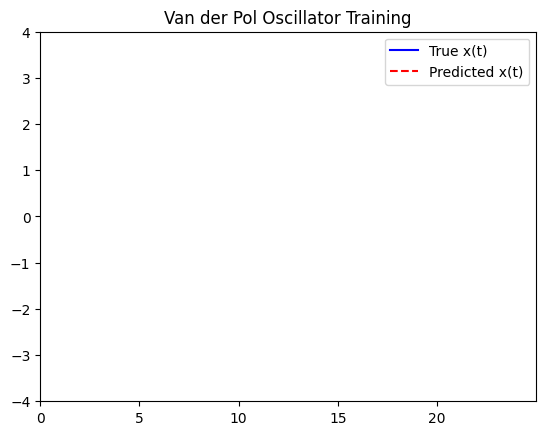

In [61]:
neural_ode, y_true, t_values = train_neural_ode(dynamic_plot=False)

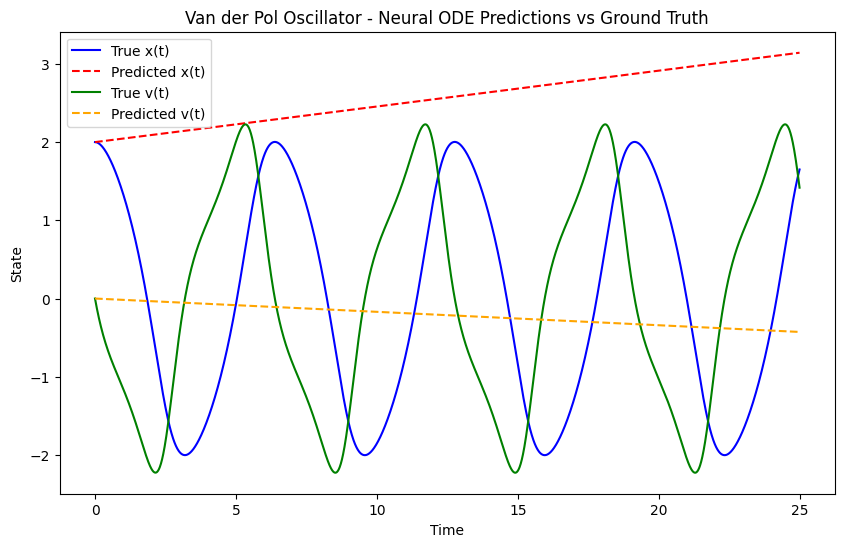

In [62]:
plot_results(neural_ode, y_true, t_values, torch.tensor([[2.0, 0.0]]), (0, 25), 0.01)

implemneation has some flaws, using torchdiffeq for the neural network layer

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint


In [64]:
class VanDerPolODE(nn.Module):
    def __init__(self, mu=1.0):
        super(VanDerPolODE, self).__init__()
        self.mu = torch.tensor(mu)

    def forward(self, t, y):
        x, v = y[..., 0], y[..., 1]
        dxdt = v
        dvdt = self.mu * (1 - x**2) * v - x
        return torch.stack([dxdt, dvdt], dim=-1)

class NeuralVanDerPol(nn.Module):
    def __init__(self):
        super(NeuralVanDerPol, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, t, y):
        out = torch.tanh(self.fc1(y))
        out = torch.tanh(self.fc2(out))
        return self.fc3(out)

def ode_solution(model, y0, t_span):
    return odeint(model, y0, t_span)

def generate_data(mu, t_span, y0):
    van_der_pol = VanDerPolODE(mu)
    with torch.no_grad():
        y_true = ode_solution(van_der_pol, y0, t_span)
    return y_true


In [65]:
def train_neural_ode(mu=1.0, epochs=1000, lr=1e-3):
    t_span = torch.linspace(0, 25, 100)
    y0 = torch.tensor([[2.0, 0.0]])

    y_true = generate_data(mu, t_span, y0)

    neural_ode = NeuralVanDerPol()

    optimizer = optim.Adam(neural_ode.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()

        y_pred = ode_solution(neural_ode, y0, t_span)

        # Compute loss
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    print("Training complete.")
    return neural_ode, y_true, t_span


def plot_results(neural_ode, y_true, t_span):
    import matplotlib.pyplot as plt
    y_pred = ode_solution(neural_ode, y_true[0], t_span).detach()

    plt.plot(t_span, y_true[:, 0, 0], label='True x(t)')
    plt.plot(t_span, y_pred[:, 0, 0], '--', label='Predicted x(t)')
    plt.plot(t_span, y_true[:, 0, 1], label='True v(t)')
    plt.plot(t_span, y_pred[:, 0, 1], '--', label='Predicted v(t)')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title('Van der Pol Oscillator - Neural ODE')
    plt.show()


In [66]:
neural_ode, y_true, t_span = train_neural_ode()

Epoch 0, Loss: 8.700078010559082
Epoch 100, Loss: 1.9260122776031494
Epoch 200, Loss: 1.8840932846069336
Epoch 300, Loss: 1.7777835130691528
Epoch 400, Loss: 1.4649358987808228
Epoch 500, Loss: 0.2754858732223511
Epoch 600, Loss: 0.1674005538225174
Epoch 700, Loss: 0.15934108197689056
Epoch 800, Loss: 0.15548592805862427
Epoch 900, Loss: 0.15306495130062103
Training complete.


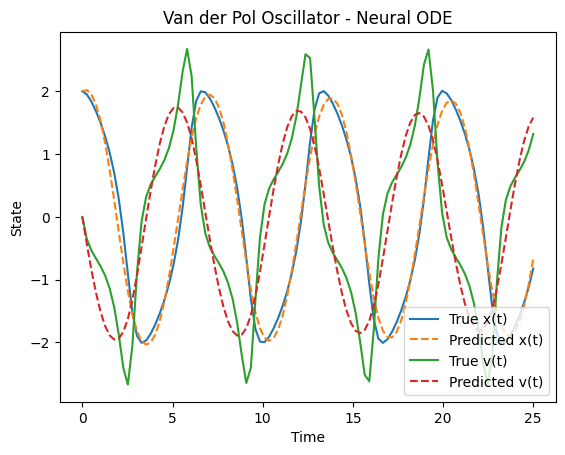

In [67]:
plot_results(neural_ode, y_true, t_span)

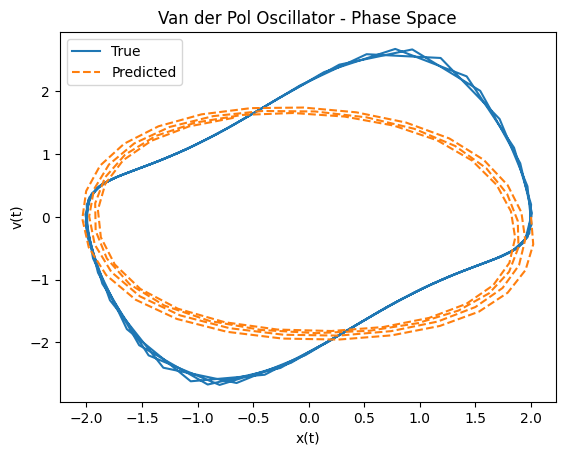

In [68]:
# plotting x(t) vs v(t) for predicted vs true

def plot_phase_space(neural_ode, y_true, t_span):
    y_pred = ode_solution(neural_ode, y_true[0], t_span).detach()

    plt.plot(y_true[:, 0, 0], y_true[:, 0, 1], label='True')
    plt.plot(y_pred[:, 0, 0], y_pred[:, 0, 1], '--', label='Predicted')
    plt.legend()
    plt.xlabel('x(t)')
    plt.ylabel('v(t)')
    plt.title('Van der Pol Oscillator - Phase Space')
    plt.show()

plot_phase_space(neural_ode, y_true, t_span)

so the neural network even with smaller and less runs compared to previosu attempt is working better, which tells me my ode solver has some issue (need to look at rk4 implementation)

In [71]:
class NeuralVanDerPol(nn.Module):
    def __init__(self):
        super(NeuralVanDerPol, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 2)

    def forward(self, t, y):
        out = torch.tanh(self.fc1(y))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        return self.fc5(out)

Epoch 0, Loss: 3.7057812213897705
Epoch 100, Loss: 1.8964401483535767
Epoch 200, Loss: 1.837302803993225
Epoch 300, Loss: 1.9516797065734863
Epoch 400, Loss: 1.8768491744995117
Epoch 500, Loss: 1.9066548347473145
Epoch 600, Loss: 1.8314087390899658
Epoch 700, Loss: 1.9401006698608398
Epoch 800, Loss: 1.8289539813995361
Epoch 900, Loss: 1.8823930025100708
Training complete.


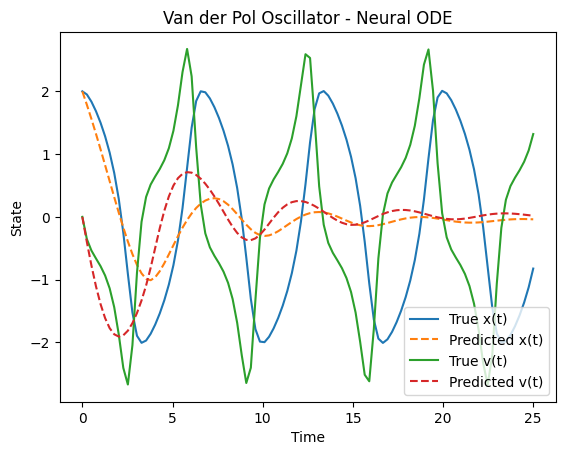

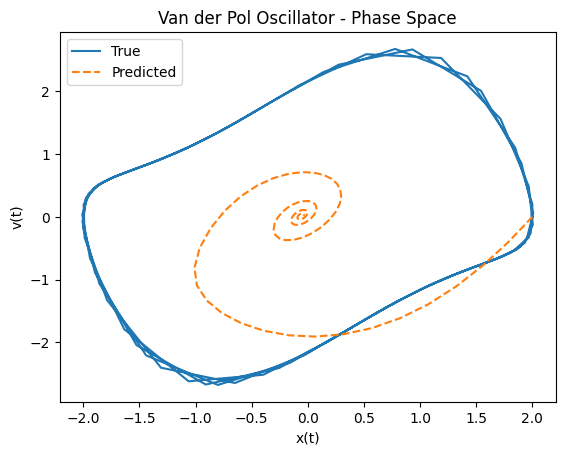

In [72]:
neural_ode, y_true, t_span = train_neural_ode()
plot_results(neural_ode, y_true, t_span)
plot_phase_space(neural_ode, y_true, t_span)